# American Census

In [21]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt

## Global config

In [2]:
# Data config
path_to_csv = "adult.csv"


## Load data

In [3]:
X_train_raw = pd.read_csv("X_train.csv")
y_train_raw = pd.read_csv("y_train.csv")

X_unknown_raw = pd.read_csv("X_test.csv")


## Helpers

In [4]:
# TODO

## Data exploration

### Question 1

In [5]:
# TODO

### Question 2

In [6]:
# TODO

## Data exploration

### Question 1

In [7]:
# Cleanup data
from sklearn.impute import SimpleImputer
from math import isnan

imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")

imp.fit(X_train_raw)
X_train_imputed = imp.transform(X_train_raw)

imp.fit(X_unknown_raw)
X_unknown_imputed = imp.transform(X_unknown_raw)

### Question 2

In [8]:
from sklearn.preprocessing import OrdinalEncoder

X_train_enc = OrdinalEncoder().fit(X_train_imputed).transform(X_train_imputed)
X_unknown_enc = OrdinalEncoder().fit(X_unknown_imputed).transform(X_unknown_imputed)

### Question 3

In [31]:
from sklearn.preprocessing import StandardScaler

X_train_processed = StandardScaler().fit(X_train_enc).transform(X_train_enc)
X_unknown_processed = StandardScaler().fit(X_unknown_enc).transform(X_unknown_enc)

## Experiments

### Question 1

In [32]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C=10, kernel="poly", random_state=42),
    "LogisticRegression": LogisticRegression(C=10, penalty="none", random_state=42),
}

# Split
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_train_raw, test_size=0.1, random_state=42, shuffle=True, stratify=y_train_raw)

### Question 2

Name                      F1 mean    F1 stddev
----------------------  ---------  -----------
GaussianNB               0.785786   0.00506149
DecisionTreeClassifier   0.786363   0.0142345
KNeighborsClassifier     0.795113   0.00862185
SVM                      0.80417    0.00781978
LogisticRegression       0.782246   0.00674239


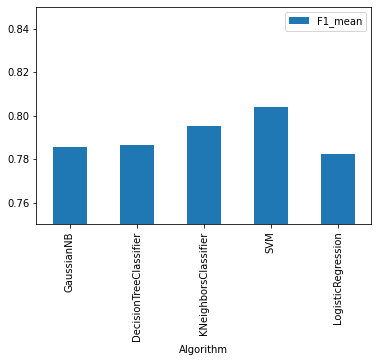

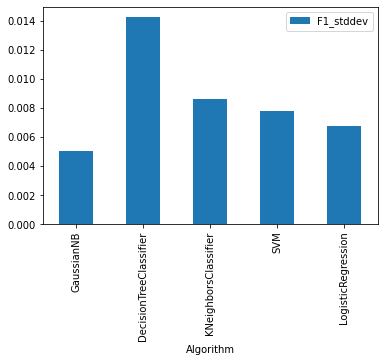

In [39]:
def k_fold_fit_and_evaluate(X, y, model, scoring_method, n_splits=5):
    # define evaluation procedure
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    # evaluate model
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=cv, n_jobs=-1)
    
       
    return scores["test_score"]

scoring_method = make_scorer(lambda prediction, true_target: f1_score(prediction, true_target, average="weighted"))

def kfold_fit_eval(X_train, y_train):
    table2 = []
    for name, model in models.items():
        kfold_scores = k_fold_fit_and_evaluate(X_train, y_train, model, scoring_method)
        m_acc = np.mean(kfold_scores)
        std_acc = np.std(kfold_scores)
        table2.append([name, m_acc, std_acc])
    return table2

kfold_eval = kfold_fit_eval(X_train, y_train.values.ravel())
from tabulate import tabulate
print(tabulate(kfold_eval, headers=['Name', 'F1 mean', 'F1 stddev']))

%matplotlib inline
df = pd.DataFrame(kfold_eval, columns=["Algorithm", "F1_mean", "F1_stddev"])
axes_mean = df.plot(x="Algorithm", y=["F1_mean"], kind="bar")
axes_mean.set_ylim(0.75, 0.85)
axes_stddev = df.plot(x="Algorithm", y=["F1_stddev"], kind="bar")

### Question 3

In [46]:
from sklearn.model_selection import GridSearchCV

random_state = 42
n_splits = 5
scoring_method = make_scorer(lambda prediction, true_target: f1_score(prediction, true_target, average="weighted"))

model_parameters = {
    "GaussianNB": {},
    "DecisionTreeClassifier": {
        'max_depth': [None, 2, 5, 10],
        'min_samples_leaf': [2],
        'random_state': [random_state]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
        'weights': ['distance']
    },
    'LogisticRegression':{
        'C': [1, 10, 100],
        'penalty': ['none', 'l2'],
        'random_state': [42]
    },
    'SVM': {
        'C': [10],
        'kernel': ['poly', 'rbf'],
        'random_state': [random_state]
    }
}

tuning_scores = []
for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(X_train_processed, y_train_raw.values.ravel())
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    tuning_scores.append([model_name, best_score])
    
    print(f"\n{model_name}")
    print("- best_score =", best_score)
    print("best parameters:")
    for k,v in best_params.items():
        print("-", k, v)


GaussianNB
- best_score = 0.7855978202920506
best parameters:

DecisionTreeClassifier
- best_score = 0.8161508324355335
best parameters:
- max_depth 10
- min_samples_leaf 2
- random_state 42

KNeighborsClassifier
- best_score = 0.8099538870319597
best parameters:
- n_neighbors 10
- weights distance

LogisticRegression
- best_score = 0.7827724970161551
best parameters:
- C 1
- penalty l2
- random_state 42

SVM
- best_score = 0.8160650905751871
best parameters:
- C 10
- kernel rbf
- random_state 42


### Question 4

(0.75, 0.85)

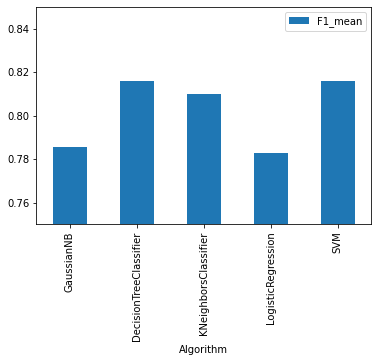

In [45]:
%matplotlib inline
df = pd.DataFrame(tuning_scores, columns=["Algorithm", "F1_mean"])
axes_mean = df.plot(x="Algorithm", y=["F1_mean"], kind="bar")
axes_mean.set_ylim(0.75, 0.85)

### Question 5

In [47]:
final_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=42)
final_model.fit(X_train, y_train.values.ravel())
prediction = final_model.predict(X_unknown_processed)
print(prediction)
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)

[0 0 0 ... 0 0 0]
